# Analog Beamforming with 1D and 2D planar arrays 
When operating high frequencies such as mmWave bands, massive MIMO (Multiple Input Multiple Output) and directional communication needs to be employed in order to overcome the greater attenuation factor and to address sparse wireless channels. Beamforming is used to steer a radiation beam of an antenna array in either 1 or 2 dimensions (depending on the array configuration) by computing and applying a _phase delay_ for each individual antenna element (also called _beam weights_). The goal is to maximize the perceived power at the receiver by knowing/estimating the direction of transmission and "steering" the  antenna _beam_-shaped radiation in that specific direction. Number and arrangement of arrays antenna elements in the 3D space determines the shape of such beam patterns, typically becoming narrower when the number of antenna elements increases. When analog phase shifters and a single RF-chain are considered for beamforming devices, we refer to it as _analog beamforming_.

First let's initialize the notebook and import `sionna`.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
    
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass


In [2]:
# Import Sionna
import os

try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed    
    os.system("pip install sionna")
    import sionna

Once `sionna` is imported, let's import the specific block for Sionna RT. After loading the desired 3D scene, we setup transmitter and receiver planar arrays with the desired configuration. Note that for this experiment we use millimiter-wave (mmWave) central frequency equal to 28 GHz (i.e. Frequency Range 2 in 5G NR).

In [3]:
# Import Sionna RT components
import tensorflow as tf
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

scene = load_scene(sionna.rt.scene.munich)
scene.frequency = 28e9  # mmwave
# Setup URA array
num_cols = 64
num_rows = 64 # set num_rows=1 for ULA

scene.tx_array = PlanarArray(num_rows=num_rows,
            num_cols=num_cols,
            vertical_spacing=0.5,
            horizontal_spacing=0.5,
            pattern="iso",
            polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="iso",
                            polarization="V")

# Transmitter
tx = Transmitter(name="tx",
                position=[45.0, 50., 15.],
                orientation=[0,0,0])
scene.add(tx)

# Receiver
rx = Receiver(name="rx",
              position=[95., 62., 10.0],
              orientation=[0,0,0])
scene.add(rx)

Then we proceed setting up cameras for 2D visualization of the scene.

/tmp/ipykernel_2719956/1295037665.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_bird.show()


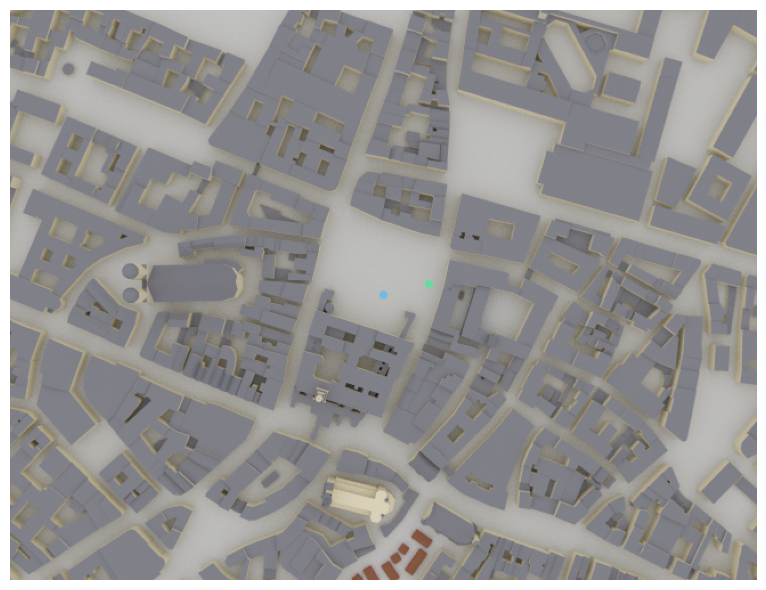

In [4]:
tx.look_at(rx)
tx_pos = scene.transmitters["tx"].position.numpy()
fancy_pos = tx_pos.copy()
fancy_pos[-3] -= 50
fancy_pos[-1] = 115  # Set height of coverage map to 1000m above tx
fancy_pos[-2] -= 100  #  move the camera for correct orientation

bird_pos = tx_pos.copy()
bird_pos[-1] = 1000  # Set height of coverage map to 1000m above tx
bird_pos[-2] -= 0.01  # Slightly move the camera for correct orientation
# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=tx.position)
fancy_cam = Camera("fancy_view", position=fancy_pos, look_at=rx.position)
scene.add(bird_cam)
scene.add(fancy_cam)

fig_bird = scene.render(camera="birds_view")
fig_bird.show()




Once we have created the desired scenario, let's experiment with different beamsteering angle configurations and study their effect on the receiver by computing a `coverage_map` for a 2D plane perpendicular to the xy-axis (i.e. `cm_orientation=[0.0, 0.5*np.pi, 0.0]`). We proceed by defining the azimuth and elevation angles we want to evaluate in this experiment and then visualize the perceived power at the receiver side when directed toward the receiver device. Note that in this case we setup the transmitter array as if _looking at_ the receiver, therefore the perfect alignment would be obtained by setting both azimuth and elevation to `0` degrees. For ease of computation, we limit our coverage map to Line-Of-Sigth (LOS) paths (i.e. `max_depth=0`).

working on degree -30


/tmp/ipykernel_2719956/168084028.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fancy2.show()


working on degree 0
working on degree 20


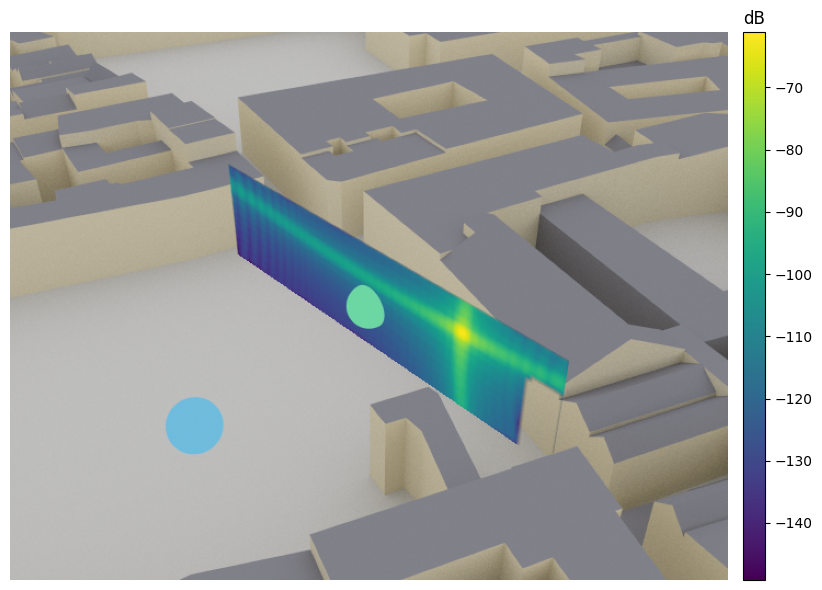

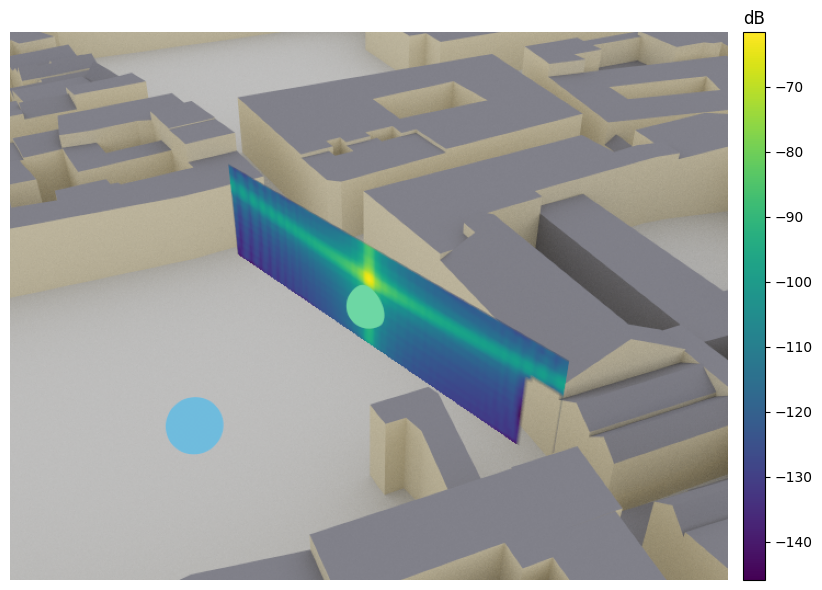

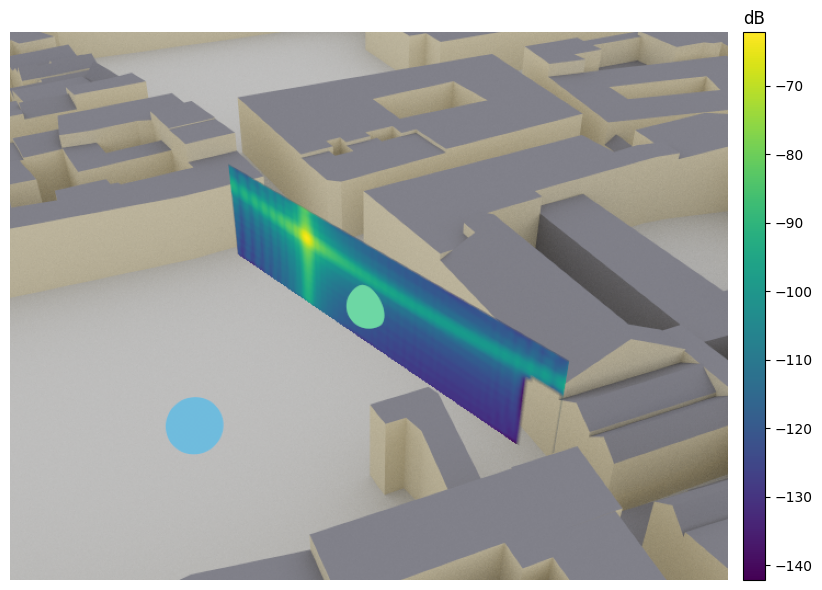

In [5]:
import numpy as np
azimuth_angles = [-30, 0, 20]
elevation_angle = 8
# Steering vector
for degree in azimuth_angles:
    print("working on degree", degree)
    steering_angle = degree  # degrees

    precoding_weights_ura = scene.tx_array.precoding_weights(azimuth_deg=steering_angle, elevation_deg=elevation_angle)

    cm = scene.coverage_map(max_depth=0, num_samples=1e6 ,cm_cell_size=[1.,1.], precoding_vec=tf.squeeze(precoding_weights_ura), cm_size=[50., 100.], cm_orientation=[0.0, 0.5*np.pi, 0.0], cm_center=[95., 62., 0.])

    scene.preview(coverage_map=cm)
    fancy2 = scene.render(camera="fancy_view", coverage_map=cm)
    fancy2.show()

In visualizations above, we see that 2D arrays beams need to be steered both in the y-axis and z-axis in order to achieve correct alignment and guarantee the highest achievable receive power at the receiver side.

## Comparison of URA and ULA radiation pattern
Let's see now how ULA array irradiates the receiver using different beam steering configurations. First, let's change the transmitter array from 64 x 64 URA to 1 x 64 ULA. Note that ULA is assumed to be aligned to y-axis.

In [6]:
scene.tx_array = PlanarArray(num_rows=1,
            num_cols=num_cols,
            vertical_spacing=0.5,
            horizontal_spacing=0.5,
            pattern="iso",
            polarization="V")

Now let's visualize the same beam steering configurations as in the previous example, but using ULA array instead of URA.

working on degree -30


/tmp/ipykernel_2719956/1360206271.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fancy2.show()


working on degree 0
working on degree 20


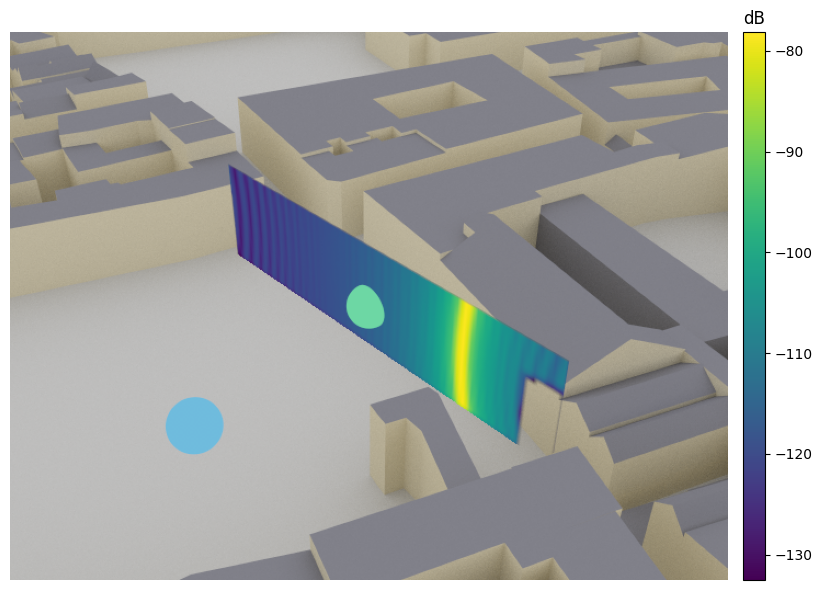

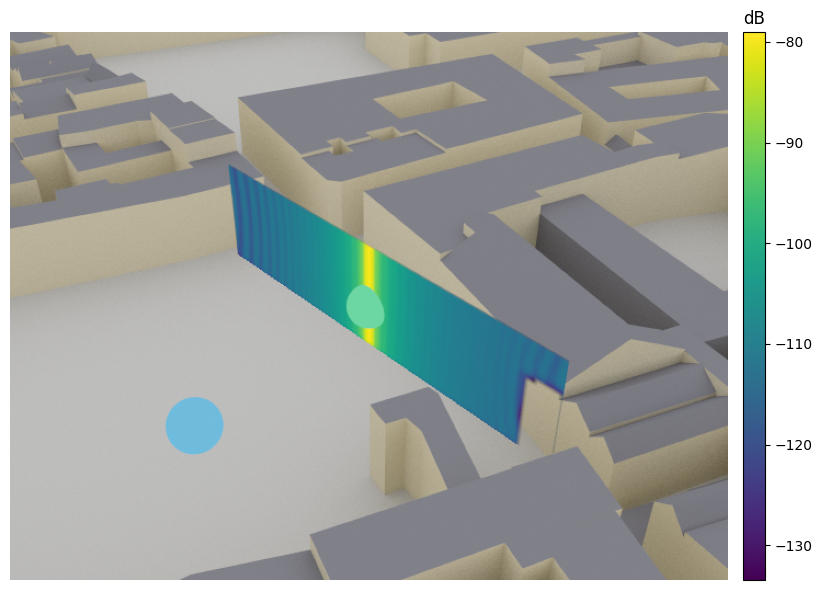

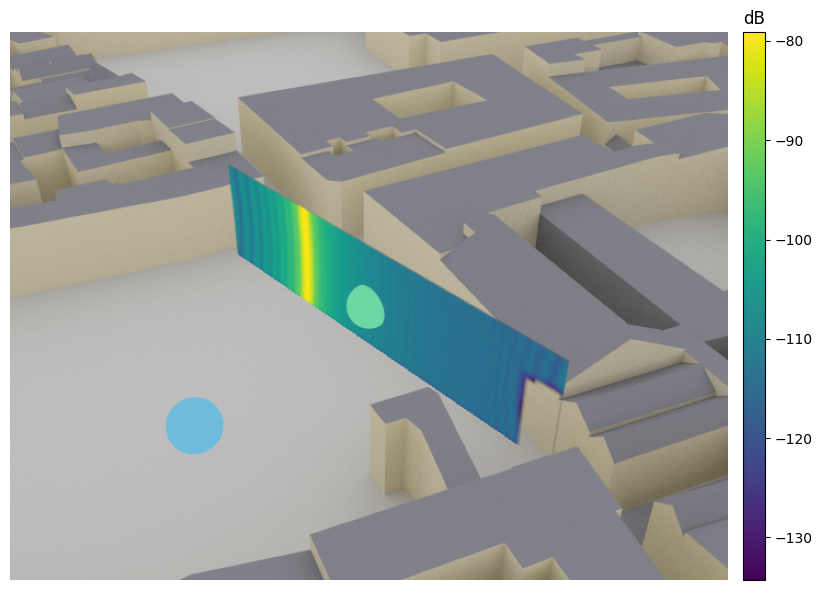

In [7]:
elevation_angle = 0
# Steering vector
for degree in azimuth_angles:
    print("working on degree", degree)
    steering_angle = degree  # degrees

    precoding_weights_ura = scene.tx_array.precoding_weights(azimuth_deg=steering_angle, elevation_deg=elevation_angle)

    cm = scene.coverage_map(max_depth=0, cm_cell_size=[1.,1.], precoding_vec=tf.squeeze(precoding_weights_ura), cm_size=[50., 100.], cm_orientation=[0.0, 0.5*np.pi, 0.0], cm_center=[95., 62., 0.])

    scene.preview(coverage_map=cm)
    fancy2 = scene.render(camera="fancy_view", coverage_map=cm)
    fancy2.show()

We note how the different structure of the array affects the received power in the area surrounding the receiver. When we use 2D beamforming (URA), the beam is narrow and concentrate the energy in a specific area of the coverage map on the yz-plane. On the other hand, for 1D beamforming (ULA) the power is spreaded equally along the vertical axis and results to be less concentrated on the specific location of the receiver.

## Conclusion
We have showed the effect of beamforming when using URA and ULA antenna devices. When employing URA, we can better focus and obtain higher concentration of power not just toward a certain direction in the azimuth plane, but also align it to a specific elevation angle.